## Imports

In [6]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from os.path import exists
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

import time
import json
import shutil

## Function Definitions
### Hand-Made Model Defintions
Add in LSTM later

In [16]:
class FeedForward(nn.Module):
    
    def __init__(self,in_dim,hid_dim,out_dim,hid_layers=0,dropout=True):
        super().__init__()
        
        if hid_layers<0:hid_layers=0
        
        if dropout:
            self.L1 = nn.Sequential(nn.Linear(in_dim,hid_dim),nn.Dropout(),nn.ReLU())
            hids = [nn.Sequential(nn.Linear(hid_dim,hid_dim),nn.Dropout(),nn.ReLU()) for i in range(hid_layers)]
        else:
            self.L1 = nn.Sequential(nn.Linear(in_dim,hid_dim),nn.ReLU())
            hids = [nn.Sequential(nn.Linear(hid_dim,hid_dim),nn.ReLU()) for i in range(hid_layers)]
            
        self.hids = nn.Sequential(*hids)
    
        self.L2 = nn.Linear(hid_dim,out_dim)
    
    def forward(self,X):
        out = self.L1(X)
        out = self.hids(out)
        out = self.L2(out)
        return out

### Function to Turn Dictionaries Into Text Documents

In [17]:
def create_text(direc):
    src_dir = f'./insts/{direc}/'
    
    dst_dir = f'./docs/{direc}/'
    if os.path.exists(dst_dir): shutil.rmtree(dst_dir)
    os.makedirs(dst_dir)
    
    for cnt in os.listdir(src_dir):
        #get dictionary
        with open (src_dir + cnt,'r') as f:
            d = json.load(f)
            
        #make string from dict
        doc = ''
        for instruction in d:
            for i in range(d[instruction]):
                doc += instruction
                doc += ' '
        
        #write string to document
        with open(dst_dir + cnt[:-5], 'w') as f:
            f.write(doc)

### Function to Generate a List of Filenames

In [18]:
def filenames(direc):
    direct = f'./docs/{direc}/'
    filename_arr = []
    for cnt in os.listdir(direct):
        filename_arr.append(direct+cnt)
    return filename_arr

### Function to Freeze Layers

In [19]:
#freeze layers of a model if desired (might want to use this generally)
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, freezing, last=False):
    if freezing:
        for param in model.parameters():
            last_param = param
            param.requires_grad = False
        if last: last_param.requires_grad = True

### Function to Prevent Weight Leakage During K-Fold Validation

In [20]:
#source: https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for child in m.children():
    req_grad = False
    for param in child.parameters():
            req_grad = req_grad or param.requires_grad
    if hasattr(child, 'reset_parameters') and req_grad:
        print(f'Reset trainable parameters of layer = {child}')
        child.reset_parameters()

### Function to Pre-Train Above Models

In [21]:
def pre_train(data,label,batch_size,hid_layers=0,printout=True,dropout=False,ff_hid_dim=10,opt=torch.optim.Adam,eta=1e-3,ff_epochs=10000):
    #Feedforward model
    ff_net = FeedForward(data.shape[1],ff_hid_dim,2,hid_layers=hid_layers,dropout=dropout)
    
    #calculate number of batches to run
    num_batches = np.ceil(data.shape[0]/batch_size).astype('int')
    
    #feedforward
    loss = nn.CrossEntropyLoss() #loss for categorization
    optimizer = opt(ff_net.parameters(), lr = eta)
    for epoch in range(ff_epochs):
        loss_calc = 0#keep a running calculation of the loss
        count = 0 # keep a running count of the number correct for the average
        
        for i in range(num_batches):
            batch_labels = label[i*batch_size:(i+1)*batch_size]
            batch_labels = torch.tensor(batch_labels).long()
            
            batch_data = data[i*batch_size:(i+1)*batch_size]
            batch_data = torch.tensor(batch_data.A).float()
            
            optimizer.zero_grad()
            predictions = ff_net(batch_data)
            train_loss = loss(predictions,batch_labels)
            train_loss.backward()
            optimizer.step()
            loss_calc += train_loss.item()
            count += (batch_labels == torch.argmax(predictions,axis=1)).sum()
        loss_calc = loss_calc/num_batches
        count = count/data.shape[0]
        if printout and (epoch+1)%1000==0: print(f"epoch : {epoch + 1}/{ff_epochs}, loss = {loss_calc}, accuracy = {count}")

    #https://pytorch.org/tutorials/beginner/saving_loading_models.html
    ff_net_path = 'ffn_net.pth'
    torch.save(ff_net.state_dict(), ff_net_path)

### Function for K-Fold Validation After Pre-Training

In [22]:
#neural net should have desired layers frozen before use with function
def kfold_val(neurn,val_per_arr,data,label,idx,batch_size,num_epochs=10000,n_splits=5,eta=1e-3,opt=torch.optim.Adam,tm=False,printout=True):
    avg_train_accs = []
    avg_val_accs = []
    avg_test_accs = []

    for val_per in val_per_arr:
        if printout: print(f"Percentage of Training Data in Validation Set : {val_per}")
        #5-fold cross validation
        #https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
        kfold = KFold(n_splits=n_splits, shuffle=True)

        train_accs = []
        val_accs = []
        test_accs = []

        for fold, (train_ids, test_ids) in enumerate(kfold.split(idx)):
            if tm: start = time.time()
            if printout: print(f'FOLD {fold+1}/{n_splits}')

            train_ids = idx[train_ids]
            test_ids = idx[test_ids]

            #split into validation and training datasets
            np.random.shuffle(train_ids)
            val_ids = train_ids[:int((val_per*len(train_ids)))]
            train_ids = train_ids[int((val_per*len(train_ids))):]
            
            test_data = np.array(data.A)[test_ids]
            test_labels = np.array(label)[test_ids]
            
            val_data = np.array(data.A)[val_ids]
            val_labels = np.array(label)[val_ids]
            
            train_data = np.array(data.A)[train_ids]
            train_labels = np.array(label)[train_ids]

            neurn.apply(reset_weights)

            loss = nn.CrossEntropyLoss() #loss for categorization
            #also influenced from layer freezing, only throw non-froze parameter into optimizer
            optimizer = opt(filter(lambda p: p.requires_grad, neurn.parameters()), lr = eta)
            
            #training set
            for epoch in range(num_epochs):
                loss_calc = 0#keep a running calculation of the loss
                count = 0 # keep a running count of the number correct for the average
                
                num_batches = np.ceil(train_data.shape[0]/batch_size).astype('int')
                for i in range(num_batches):
                    batch_labels = train_labels[i*batch_size:(i+1)*batch_size]
                    batch_labels = torch.tensor(batch_labels).long()

                    batch_data = train_data[i*batch_size:(i+1)*batch_size]
                    batch_data = torch.tensor(batch_data).float()
                
                    optimizer.zero_grad()
                    predictions = neurn(batch_data)
                    train_loss = loss(predictions,batch_labels)
                    train_loss.backward()
                    optimizer.step()
                    loss_calc += train_loss.item()
                    count += (batch_labels == torch.argmax(predictions,axis=1)).sum()
                loss_calc = loss_calc/num_batches
                count = count/len(train_ids)
                if printout and (epoch+1)%1000==0: print(f"epoch : {epoch + 1}/{num_epochs}, loss = {loss_calc}, accuracy = {count}")
            train_accs.append(count)
            with torch.no_grad():
                #validation set
                count = 0 # keep a running count of the number correct for the average
                num_batches = np.ceil(val_data.shape[0]/batch_size).astype('int')
                for i in range(num_batches):
                    batch_labels = val_labels[i*batch_size:(i+1)*batch_size]
                    batch_labels = torch.tensor(batch_labels).long()
                    batch_data = val_data[i*batch_size:(i+1)*batch_size]
                    batch_data = torch.tensor(batch_data).float()
                    predictions = neurn(batch_data)
                    count += (batch_labels == torch.argmax(predictions,axis=1)).sum()
                count = count/len(val_ids)
                if printout: print(f"Validation Accuracy = {count}")
                val_accs.append(count)
                #test set
                count = 0 # keep a running count of the number correct for the average
                num_batches = np.ceil(test_data.shape[0]/batch_size).astype('int')
                for i in range(num_batches):
                    batch_labels = test_labels[i*batch_size:(i+1)*batch_size]
                    batch_labels = torch.tensor(batch_labels).long()
                    batch_data = test_data[i*batch_size:(i+1)*batch_size]
                    batch_data = torch.tensor(batch_data).float()
                    predictions = neurn(batch_data)
                    count += (batch_labels == torch.argmax(predictions,axis=1)).sum()
                count = count/len(test_ids)
                if printout: print(f"Test Accuracy = {count}")
                test_accs.append(count)
            if tm: print(f"Time for Fold: {time.time()-start}")
        if printout: print(f"Average Training Accuracy: {sum(train_accs)/len(train_accs)}")
        avg_train_accs.append(sum(train_accs)/len(train_accs))
        if printout: print(f"Average Validation Accuracy: {sum(val_accs)/len(val_accs)}")
        avg_val_accs.append(sum(val_accs)/len(val_accs))
        if printout: print(f"Average Testing Accuracy: {sum(test_accs)/len(test_accs)}")
        avg_test_accs.append(sum(test_accs)/len(test_accs))
        
    return avg_train_accs, avg_val_accs, avg_test_accs

## GPU check

In [23]:
is_cuda = torch.cuda.is_available()
if is_cuda: device = torch.device("cuda")
else: device = torch.device("cpu")

## Create Text Documents and Split Into Pre-Train and Transfer Sets

In [10]:
#change dictionaries to text documents
create_text('ben_back')
create_text('ben_test')
create_text('mal_none')
create_text('mal_som_4000')

In [24]:
#generate file names
ben_names = filenames('ben_back') + filenames('ben_test')
mal_some_names = filenames('mal_som_4000')
mal_none_names = filenames('mal_none')

In [25]:
#generate random indices of benign binaries to pair with malware sets
idx = np.random.choice(np.arange(len(ben_names)),size = len(mal_none_names)+len(mal_some_names))

#generate the benign pairs for malware detected by av software
pair_some_i = idx[:len(mal_some_names)]
ben_some_names = np.array(ben_names)[pair_some_i]

#generate the benign pairs for malware not detected by av software
pair_none_i = idx[len(mal_some_names):]
ben_none_names = np.array(ben_names)[pair_none_i]

# **Case 1**: No Dropout, No Hidden Layers

## Get Pre-Trained Models

In [13]:
tfidf = TfidfVectorizer(input='filename')
pretrain_data = tfidf.fit_transform(np.append(ben_some_names,np.array(mal_some_names)))

In [19]:
ff_hid_dim = 30
no_valid_paths = True

if no_valid_paths:
    if exists('ffn_net.pth'): os.remove('ffn_net.pth')
    #set labels for pre-trained data
    pretrain_labels = np.append(np.zeros(len(ben_some_names)),np.ones(len(mal_some_names)))
    #size of batches
    batch_size = 200
    pre_train(pretrain_data,pretrain_labels,batch_size=batch_size,ff_hid_dim=ff_hid_dim,ff_epochs=10000)

epoch : 1000/10000, loss = 0.15399125466744104, accuracy = 0.9424809217453003
epoch : 2000/10000, loss = 0.09107577291627725, accuracy = 0.9653499722480774
epoch : 3000/10000, loss = 0.0599954042583704, accuracy = 0.9771309494972229
epoch : 4000/10000, loss = 0.04145602708061536, accuracy = 0.9861400127410889
epoch : 5000/10000, loss = 0.028495907224714755, accuracy = 0.9920305013656616
epoch : 6000/10000, loss = 0.019654363549004, accuracy = 0.9944559931755066
epoch : 7000/10000, loss = 0.013418219548960527, accuracy = 0.9951490163803101
epoch : 8000/10000, loss = 0.009602422391374906, accuracy = 0.9961885213851929
epoch : 9000/10000, loss = 0.007136107313757142, accuracy = 0.9968814849853516
epoch : 10000/10000, loss = 0.005634201826372494, accuracy = 0.9972280263900757


## Get Data and Labels for Transfer Data

In [20]:
transfer_data = tfidf.transform(np.append(ben_none_names,np.array(mal_none_names)))
transfer_labels = np.append(np.zeros(len(ben_none_names)),np.ones(len(mal_none_names)))

## Get Network for Freezing a Single Layer

In [21]:
ff_net_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,dropout=False)
ff_net_freeze.load_state_dict(torch.load('ffn_net.pth'))
set_parameter_requires_grad(ff_net_freeze, True)
ff_net_freeze.L2 = nn.Linear(ff_hid_dim,2)

## Get Network for Transfer With No Freezing

In [22]:
ff_net_no_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,dropout=False)
ff_net_no_freeze.load_state_dict(torch.load('ffn_net.pth'))

<All keys matched successfully>

## Train The NNs

In [23]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99] # the percentages of training data in the validation set
plt_arr = [1 - i for i in val_per_arr] #make array signifying percentage in training set
ff_train_freeze,ff_val_freeze,ff_test_freeze = kfold_val(ff_net_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_train_no_freeze,ff_val_no_freeze,ff_test_no_freeze = kfold_val(ff_net_no_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_net_no_transfer = FeedForward(transfer_data.shape[1],ff_hid_dim,2,dropout=False) #network for no transfer
ff_train_no_transfer,ff_val_no_transfer,ff_test_no_transfer = kfold_val(ff_net_no_transfer,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)

Percentage of Training Data in Validation Set : 0.1
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.472784161567688, accuracy = 0.7847222089767456
epoch : 2000/10000, loss = 0.43261563777923584, accuracy = 0.8194444179534912
epoch : 3000/10000, loss = 0.4089936316013336, accuracy = 0.8263888955116272
epoch : 4000/10000, loss = 0.39249497652053833, accuracy = 0.8263888955116272
epoch : 5000/10000, loss = 0.37973108887672424, accuracy = 0.8402777910232544
epoch : 6000/10000, loss = 0.3692619502544403, accuracy = 0.8402777910232544
epoch : 7000/10000, loss = 0.36040446162223816, accuracy = 0.8472222089767456
epoch : 8000/10000, loss = 0.35301655530929565, accuracy = 0.8541666865348816
epoch : 9000/10000, loss = 0.34692054986953735, accuracy = 0.8472222089767456
epoch : 10000/10000, loss = 0.34173834323883057, accuracy = 0.8541666865348816
Validation Accuracy = 0.75
Test Accuracy = 0.800000011920929
FOLD 2/5
Rese

epoch : 1000/10000, loss = 0.4249693751335144, accuracy = 0.84375
epoch : 2000/10000, loss = 0.3885328471660614, accuracy = 0.8515625
epoch : 3000/10000, loss = 0.36488834023475647, accuracy = 0.859375
epoch : 4000/10000, loss = 0.3458114266395569, accuracy = 0.8671875
epoch : 5000/10000, loss = 0.32939282059669495, accuracy = 0.875
epoch : 6000/10000, loss = 0.31522759795188904, accuracy = 0.8828125
epoch : 7000/10000, loss = 0.3032720685005188, accuracy = 0.8828125
epoch : 8000/10000, loss = 0.29325854778289795, accuracy = 0.890625
epoch : 9000/10000, loss = 0.2847699224948883, accuracy = 0.890625
epoch : 10000/10000, loss = 0.2774229943752289, accuracy = 0.890625
Validation Accuracy = 0.75
Test Accuracy = 0.824999988079071
Average Training Accuracy: 0.8765624761581421
Average Validation Accuracy: 0.7749999761581421
Average Testing Accuracy: 0.7950000166893005
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out

epoch : 1000/10000, loss = 0.47718724608421326, accuracy = 0.8333333134651184
epoch : 2000/10000, loss = 0.42194676399230957, accuracy = 0.84375
epoch : 3000/10000, loss = 0.3926713764667511, accuracy = 0.8229166865348816
epoch : 4000/10000, loss = 0.37389644980430603, accuracy = 0.84375
epoch : 5000/10000, loss = 0.36043891310691833, accuracy = 0.8541666865348816
epoch : 6000/10000, loss = 0.3501875102519989, accuracy = 0.8541666865348816
epoch : 7000/10000, loss = 0.3419567346572876, accuracy = 0.8645833134651184
epoch : 8000/10000, loss = 0.3350203037261963, accuracy = 0.8645833134651184
epoch : 9000/10000, loss = 0.32901132106781006, accuracy = 0.8645833134651184
epoch : 10000/10000, loss = 0.32372191548347473, accuracy = 0.8645833134651184
Validation Accuracy = 0.78125
Test Accuracy = 0.800000011920929
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.44134703278541565, accuracy = 0.8645833134651184
epoch 

epoch : 10000/10000, loss = 0.28980112075805664, accuracy = 0.90625
Validation Accuracy = 0.7395833134651184
Test Accuracy = 0.7749999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.37903478741645813, accuracy = 0.859375
epoch : 2000/10000, loss = 0.3036351203918457, accuracy = 0.890625
epoch : 3000/10000, loss = 0.2591799199581146, accuracy = 0.921875
epoch : 4000/10000, loss = 0.22796237468719482, accuracy = 0.9375
epoch : 5000/10000, loss = 0.20330259203910828, accuracy = 0.9375
epoch : 6000/10000, loss = 0.18227455019950867, accuracy = 0.9375
epoch : 7000/10000, loss = 0.16400399804115295, accuracy = 0.953125
epoch : 8000/10000, loss = 0.14831720292568207, accuracy = 0.96875
epoch : 9000/10000, loss = 0.13498830795288086, accuracy = 0.96875
epoch : 10000/10000, loss = 0.12366731464862823, accuracy = 0.96875
Validation Accuracy = 0.7708333134651184
Test Accuracy = 0.7749999761581421
FOLD 4/5
Rese

epoch : 1000/10000, loss = 0.3830355405807495, accuracy = 0.875
epoch : 2000/10000, loss = 0.2746478021144867, accuracy = 0.96875
epoch : 3000/10000, loss = 0.20427058637142181, accuracy = 1.0
epoch : 4000/10000, loss = 0.1542297750711441, accuracy = 1.0
epoch : 5000/10000, loss = 0.1174338236451149, accuracy = 1.0
epoch : 6000/10000, loss = 0.08989010006189346, accuracy = 1.0
epoch : 7000/10000, loss = 0.06903441995382309, accuracy = 1.0
epoch : 8000/10000, loss = 0.05313171073794365, accuracy = 1.0
epoch : 9000/10000, loss = 0.04095563665032387, accuracy = 1.0
epoch : 10000/10000, loss = 0.03161020576953888, accuracy = 1.0
Validation Accuracy = 0.6484375
Test Accuracy = 0.675000011920929
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.4134065806865692, accuracy = 0.875
epoch : 2000/10000, loss = 0.3242446780204773, accuracy = 0.875
epoch : 3000/10000, loss = 0.27813833951950073, accuracy = 0.90625
epoch : 4

epoch : 10000/10000, loss = 0.0015414259396493435, accuracy = 1.0
Validation Accuracy = 0.7368420958518982
Test Accuracy = 0.699999988079071
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.22365587949752808, accuracy = 0.875
epoch : 2000/10000, loss = 0.13221222162246704, accuracy = 1.0
epoch : 3000/10000, loss = 0.08135168254375458, accuracy = 1.0
epoch : 4000/10000, loss = 0.051573604345321655, accuracy = 1.0
epoch : 5000/10000, loss = 0.033384110778570175, accuracy = 1.0
epoch : 6000/10000, loss = 0.021910473704338074, accuracy = 1.0
epoch : 7000/10000, loss = 0.014510288834571838, accuracy = 1.0
epoch : 8000/10000, loss = 0.009665852412581444, accuracy = 1.0
epoch : 9000/10000, loss = 0.0064633069559931755, accuracy = 1.0
epoch : 10000/10000, loss = 0.004332488868385553, accuracy = 1.0
Validation Accuracy = 0.7565789222717285
Test Accuracy = 0.824999988079071
FOLD 3/5
Reset trainable parameters of layer =

epoch : 5000/10000, loss = 0.0006001058500260115, accuracy = 1.0
epoch : 6000/10000, loss = 0.0003038368886336684, accuracy = 1.0
epoch : 7000/10000, loss = 0.00016062520444393158, accuracy = 1.0
epoch : 8000/10000, loss = 8.728031389182433e-05, accuracy = 1.0
epoch : 9000/10000, loss = 4.8322821385227144e-05, accuracy = 1.0
epoch : 10000/10000, loss = 2.711388333409559e-05, accuracy = 1.0
Validation Accuracy = 0.75
Test Accuracy = 0.8500000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.09832390397787094, accuracy = 0.9791666865348816
epoch : 2000/10000, loss = 0.026281246915459633, accuracy = 1.0
epoch : 3000/10000, loss = 0.008641477674245834, accuracy = 1.0
epoch : 4000/10000, loss = 0.003430735319852829, accuracy = 1.0
epoch : 5000/10000, loss = 0.001550569897517562, accuracy = 1.0
epoch : 6000/10000, loss

epoch : 3000/10000, loss = 0.005455590318888426, accuracy = 1.0
epoch : 4000/10000, loss = 0.002202991396188736, accuracy = 1.0
epoch : 5000/10000, loss = 0.0010099789360538125, accuracy = 1.0
epoch : 6000/10000, loss = 0.0005000089877285063, accuracy = 1.0
epoch : 7000/10000, loss = 0.0002597584098111838, accuracy = 1.0
epoch : 8000/10000, loss = 0.00013928084808867425, accuracy = 1.0
epoch : 9000/10000, loss = 7.631467451574281e-05, accuracy = 1.0
epoch : 10000/10000, loss = 4.245664240443148e-05, accuracy = 1.0
Validation Accuracy = 0.84375
Test Accuracy = 0.875
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.831250011920929
Average Testing Accuracy: 0.8500000238418579
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.0647086501121521, accuracy = 0.991071

epoch : 1000/10000, loss = 0.027666812762618065, accuracy = 1.0
epoch : 2000/10000, loss = 0.005077329929918051, accuracy = 1.0
epoch : 3000/10000, loss = 0.0017371129943057895, accuracy = 1.0
epoch : 4000/10000, loss = 0.0007518005440942943, accuracy = 1.0
epoch : 5000/10000, loss = 0.0003644053649622947, accuracy = 1.0
epoch : 6000/10000, loss = 0.00018804759019985795, accuracy = 1.0
epoch : 7000/10000, loss = 0.00010073912562802434, accuracy = 1.0
epoch : 8000/10000, loss = 5.52723795408383e-05, accuracy = 1.0
epoch : 9000/10000, loss = 3.082701005041599e-05, accuracy = 1.0
epoch : 10000/10000, loss = 1.7393902453477494e-05, accuracy = 1.0
Validation Accuracy = 0.8125
Test Accuracy = 0.8500000238418579
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.06677203625440598, accuracy = 0.9895833134651184
epoch : 2000/10000, 

epoch : 1000/10000, loss = 0.019289782270789146, accuracy = 1.0
epoch : 2000/10000, loss = 0.0034220542293041945, accuracy = 1.0
epoch : 3000/10000, loss = 0.0011256684083491564, accuracy = 1.0
epoch : 4000/10000, loss = 0.00047808969975449145, accuracy = 1.0
epoch : 5000/10000, loss = 0.00022970355348661542, accuracy = 1.0
epoch : 6000/10000, loss = 0.00011807226110249758, accuracy = 1.0
epoch : 7000/10000, loss = 6.313981430139393e-05, accuracy = 1.0
epoch : 8000/10000, loss = 3.4625816624611616e-05, accuracy = 1.0
epoch : 9000/10000, loss = 1.9303068256704137e-05, accuracy = 1.0
epoch : 10000/10000, loss = 1.0897897482209373e-05, accuracy = 1.0
Validation Accuracy = 0.8229166865348816
Test Accuracy = 0.699999988079071
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.054764457046985626, accuracy = 1.0
epoch : 2000/10000

epoch : 10000/10000, loss = 9.778714229469188e-06, accuracy = 1.0
Validation Accuracy = 0.84375
Test Accuracy = 0.8500000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.026899447664618492, accuracy = 1.0
epoch : 2000/10000, loss = 0.004558009561151266, accuracy = 1.0
epoch : 3000/10000, loss = 0.0015192653518170118, accuracy = 1.0
epoch : 4000/10000, loss = 0.0006517627043649554, accuracy = 1.0
epoch : 5000/10000, loss = 0.0003151092678308487, accuracy = 1.0
epoch : 6000/10000, loss = 0.00016256887465715408, accuracy = 1.0
epoch : 7000/10000, loss = 8.716403681319207e-05, accuracy = 1.0
epoch : 8000/10000, loss = 4.7877700126264244e-05, accuracy = 1.0
epoch : 9000/10000, loss = 2.672788468771614e-05, accuracy = 1.0
epoch : 10000/10000, loss = 1.5105710190255195e-05, accuracy = 1.0
Validation Accuracy = 0.8125
T

epoch : 8000/10000, loss = 4.173630441073328e-05, accuracy = 1.0
epoch : 9000/10000, loss = 2.3394244635710493e-05, accuracy = 1.0
epoch : 10000/10000, loss = 1.3239497093309183e-05, accuracy = 1.0
Validation Accuracy = 0.7708333134651184
Test Accuracy = 0.675000011920929
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.8069444894790649
Average Testing Accuracy: 0.8100000619888306
Percentage of Training Data in Validation Set : 0.95
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.004864563699811697, accuracy = 1.0
epoch : 2000/10000, loss = 0.0010177602525800467, accuracy = 1.0
epoch : 3000/10000, loss = 0.00037943333154544234, accuracy = 1.0
epoch : 4000/10000, loss = 0.00017363717779517174, accuracy = 1.0
epoch : 5000/10000, loss = 8.764326048549265e-05, accuracy = 1.0
epoch : 6000/10000, loss = 4.66540077

epoch : 3000/10000, loss = 9.071372187463567e-05, accuracy = 1.0
epoch : 4000/10000, loss = 4.26759070251137e-05, accuracy = 1.0
epoch : 5000/10000, loss = 2.187463360314723e-05, accuracy = 1.0
epoch : 6000/10000, loss = 1.1861244274768978e-05, accuracy = 1.0
epoch : 7000/10000, loss = 6.616090558964061e-06, accuracy = 1.0
epoch : 8000/10000, loss = 3.7550844353972934e-06, accuracy = 1.0
epoch : 9000/10000, loss = 2.0861598386545666e-06, accuracy = 1.0
epoch : 10000/10000, loss = 1.2516966307885014e-06, accuracy = 1.0
Validation Accuracy = 0.5
Test Accuracy = 0.4749999940395355
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.001008263323456049, accuracy = 1.0
epoch : 2000/10000, loss = 0.00023725569189991802, accuracy = 1.0
epoch : 3000/10000, loss = 9.262097591999918e-05, accuracy = 1.0
epoch : 4000/10000, loss = 4.3510

epoch : 1000/10000, loss = 0.058822181075811386, accuracy = 0.9921875
epoch : 2000/10000, loss = 0.01457519643008709, accuracy = 1.0
epoch : 3000/10000, loss = 0.004873635247349739, accuracy = 1.0
epoch : 4000/10000, loss = 0.001983967609703541, accuracy = 1.0
epoch : 5000/10000, loss = 0.0009136315202340484, accuracy = 1.0
epoch : 6000/10000, loss = 0.00045350351138040423, accuracy = 1.0
epoch : 7000/10000, loss = 0.00023594404046889395, accuracy = 1.0
epoch : 8000/10000, loss = 0.0001266237086383626, accuracy = 1.0
epoch : 9000/10000, loss = 6.940960884094238e-05, accuracy = 1.0
epoch : 10000/10000, loss = 3.863767778966576e-05, accuracy = 1.0
Validation Accuracy = 1.0
Test Accuracy = 0.800000011920929
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.07472506165504456, accuracy = 0.9765625
epoch : 2000/10000, loss = 0.0

epoch : 10000/10000, loss = 3.555910734576173e-05, accuracy = 1.0
Validation Accuracy = 0.8125
Test Accuracy = 0.8500000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.05103417858481407, accuracy = 1.0
epoch : 2000/10000, loss = 0.010000721551477909, accuracy = 1.0
epoch : 3000/10000, loss = 0.0032702255994081497, accuracy = 1.0
epoch : 4000/10000, loss = 0.0013632833724841475, accuracy = 1.0
epoch : 5000/10000, loss = 0.00064391567138955, accuracy = 1.0
epoch : 6000/10000, loss = 0.00032623589504510164, accuracy = 1.0
epoch : 7000/10000, loss = 0.00017235962150152773, accuracy = 1.0
epoch : 8000/10000, loss = 9.353571658721194e-05, accuracy = 1.0
epoch : 9000/10000, loss = 5.1712599088205025e-05, accuracy = 1.0
epoch : 10000/10000, loss = 2.895412217185367e-05, accuracy = 1.0
Validation Accuracy = 0.859375
Tes

epoch : 8000/10000, loss = 0.00026158569380640984, accuracy = 1.0
epoch : 9000/10000, loss = 0.00014545058365911245, accuracy = 1.0
epoch : 10000/10000, loss = 8.221952884923667e-05, accuracy = 1.0
Validation Accuracy = 0.887499988079071
Test Accuracy = 0.949999988079071
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.8474999666213989
Average Testing Accuracy: 0.824999988079071
Percentage of Training Data in Validation Set : 0.6
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.036973144859075546, accuracy = 1.0
epoch : 2000/10000, loss = 0.006020769476890564, accuracy = 1.0
epoch : 3000/10000, loss = 0.0019530452555045485, accuracy = 1.0
epoch : 4000/10000, loss = 0.0008278244058601558, accuracy = 1.0
epoch : 5000/10000, loss = 0.0003977053565904498, accuracy = 1.0
epoch : 6000/10000, loss = 0.00020444144320

epoch : 3000/10000, loss = 0.00218240381218493, accuracy = 1.0
epoch : 4000/10000, loss = 0.0009330518078058958, accuracy = 1.0
epoch : 5000/10000, loss = 0.0004495676839724183, accuracy = 1.0
epoch : 6000/10000, loss = 0.0002312735450686887, accuracy = 1.0
epoch : 7000/10000, loss = 0.0001236712996615097, accuracy = 1.0
epoch : 8000/10000, loss = 6.778605893487111e-05, accuracy = 1.0
epoch : 9000/10000, loss = 3.777404344873503e-05, accuracy = 1.0
epoch : 10000/10000, loss = 2.1290359654813074e-05, accuracy = 1.0
Validation Accuracy = 0.8392857313156128
Test Accuracy = 0.7749999761581421
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.0468980073928833, accuracy = 1.0
epoch : 2000/10000, loss = 0.00820873025804758, accuracy = 1.0
epoch : 3000/10000, loss = 0.002552599413320422, accuracy = 1.0
epoch : 4000/10000, loss = 0

epoch : 1000/10000, loss = 0.009820759296417236, accuracy = 1.0
epoch : 2000/10000, loss = 0.0019120988436043262, accuracy = 1.0
epoch : 3000/10000, loss = 0.0006871752557344735, accuracy = 1.0
epoch : 4000/10000, loss = 0.0003073903499171138, accuracy = 1.0
epoch : 5000/10000, loss = 0.00015264625835698098, accuracy = 1.0
epoch : 6000/10000, loss = 8.024158887565136e-05, accuracy = 1.0
epoch : 7000/10000, loss = 4.3613141315290704e-05, accuracy = 1.0
epoch : 8000/10000, loss = 2.4221046260208823e-05, accuracy = 1.0
epoch : 9000/10000, loss = 1.3626860891235992e-05, accuracy = 1.0
epoch : 10000/10000, loss = 7.763424036966171e-06, accuracy = 1.0
Validation Accuracy = 0.8263888955116272
Test Accuracy = 0.8999999761581421
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.015748843550682068, accuracy = 1.0
epoch : 2000/10000,

epoch : 10000/10000, loss = 1.8477420553608681e-06, accuracy = 1.0
Validation Accuracy = 0.4873417615890503
Test Accuracy = 0.5249999761581421
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.00619930773973465, accuracy = 1.0
epoch : 2000/10000, loss = 0.001277700997889042, accuracy = 1.0
epoch : 3000/10000, loss = 0.0004738635616376996, accuracy = 1.0
epoch : 4000/10000, loss = 0.00021616261801682413, accuracy = 1.0
epoch : 5000/10000, loss = 0.00010889174154726788, accuracy = 1.0
epoch : 6000/10000, loss = 5.787442933069542e-05, accuracy = 1.0
epoch : 7000/10000, loss = 3.1709168979432434e-05, accuracy = 1.0
epoch : 8000/10000, loss = 1.770242306520231e-05, accuracy = 1.0
epoch : 9000/10000, loss = 1.0013530300057027e-05, accuracy = 1.0
epoch : 10000/10000, loss = 5.781633717560908e-06, accuracy = 1.0
Validation Accurac

### Plot of the Above

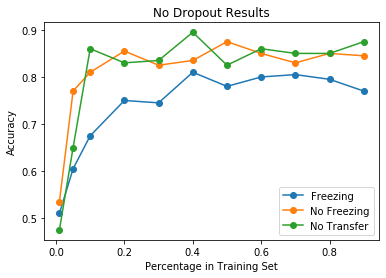

In [24]:
plt.plot(plt_arr,ff_test_freeze,'-o',label="Freezing")
plt.plot(plt_arr,ff_test_no_freeze,'-o', label = "No Freezing")
plt.plot(plt_arr,ff_test_no_transfer,'-o', label = "No Transfer")
plt.title("No Dropout Results")
plt.ylabel("Accuracy")
plt.xlabel("Percentage in Training Set")
plt.legend()
plt.show()

# **Case 2**: Dropout, No Hidden Layers
## Get Pre-Trained Models

In [25]:
tfidf = TfidfVectorizer(input='filename')
pretrain_data = tfidf.fit_transform(np.append(ben_some_names,np.array(mal_some_names)))

In [26]:
ff_hid_dim = 30
no_valid_paths = True

if no_valid_paths:
    if exists('./ffn_net.pth'): os.remove('./ffn_net.pth')
    #set labels for pre-trained data
    pretrain_labels = np.append(np.zeros(len(ben_some_names)),np.ones(len(mal_some_names)))
    #size of batches
    batch_size = 200
    pre_train(pretrain_data,pretrain_labels,batch_size=batch_size,ff_hid_dim=ff_hid_dim,dropout=True,ff_epochs=10000)

epoch : 1000/10000, loss = 0.20951153039932252, accuracy = 0.9178794026374817
epoch : 2000/10000, loss = 0.1555544634660085, accuracy = 0.9393624663352966
epoch : 3000/10000, loss = 0.1175960622727871, accuracy = 0.954954981803894
epoch : 4000/10000, loss = 0.09635872965057692, accuracy = 0.9594594836235046
epoch : 5000/10000, loss = 0.07981354172031084, accuracy = 0.967428982257843
epoch : 6000/10000, loss = 0.0734020672738552, accuracy = 0.9702009558677673
epoch : 7000/10000, loss = 0.06134011410176754, accuracy = 0.9767844676971436
epoch : 8000/10000, loss = 0.05678890223304431, accuracy = 0.9788634777069092
epoch : 9000/10000, loss = 0.04746235782901446, accuracy = 0.982328474521637
epoch : 10000/10000, loss = 0.04454305979112784, accuracy = 0.9826749563217163


## Get Data and Labels for Transfer Data

In [27]:
transfer_data = tfidf.transform(np.append(ben_none_names,np.array(mal_none_names)))
transfer_labels = np.append(np.zeros(len(ben_none_names)),np.ones(len(mal_none_names)))

## Get Network for Freezing a Single Layer

In [28]:
ff_net_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2)
ff_net_freeze.load_state_dict(torch.load('ffn_net.pth'))
set_parameter_requires_grad(ff_net_freeze, True)
ff_net_freeze.L2 = nn.Linear(ff_hid_dim,2)

## Get Network for Transfer With No Freezing

In [29]:
ff_net_no_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2)
ff_net_no_freeze.load_state_dict(torch.load('ffn_net.pth'))

<All keys matched successfully>

## Train The NNs

In [30]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99] # the percentages of training data in the validation set
plt_arr = [1 - i for i in val_per_arr] #make array signifying percentage in training set
ff_train_freeze,ff_val_freeze,ff_test_freeze = kfold_val(ff_net_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_train_no_freeze,ff_val_no_freeze,ff_test_no_freeze = kfold_val(ff_net_no_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_net_no_transfer = FeedForward(transfer_data.shape[1],ff_hid_dim,2) #network for no transfer
ff_train_no_transfer,ff_val_no_transfer,ff_test_no_transfer = kfold_val(ff_net_no_transfer,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)

Percentage of Training Data in Validation Set : 0.1
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6656593084335327, accuracy = 0.6458333134651184
epoch : 2000/10000, loss = 0.6159193515777588, accuracy = 0.6388888955116272
epoch : 3000/10000, loss = 0.6378985047340393, accuracy = 0.6944444179534912
epoch : 4000/10000, loss = 0.5883511304855347, accuracy = 0.6944444179534912
epoch : 5000/10000, loss = 0.6400236487388611, accuracy = 0.6666666865348816
epoch : 6000/10000, loss = 0.6230577826499939, accuracy = 0.6875
epoch : 7000/10000, loss = 0.6347218155860901, accuracy = 0.6527777910232544
epoch : 8000/10000, loss = 0.655443549156189, accuracy = 0.6875
epoch : 9000/10000, loss = 0.6174853444099426, accuracy = 0.6875
epoch : 10000/10000, loss = 0.6172041893005371, accuracy = 0.6458333134651184
Validation Accuracy = 0.5625
Test Accuracy = 0.5
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=30

epoch : 2000/10000, loss = 0.6324090361595154, accuracy = 0.6640625
epoch : 3000/10000, loss = 0.6352789402008057, accuracy = 0.6640625
epoch : 4000/10000, loss = 0.5906047821044922, accuracy = 0.6953125
epoch : 5000/10000, loss = 0.5996230244636536, accuracy = 0.671875
epoch : 6000/10000, loss = 0.6286734342575073, accuracy = 0.671875
epoch : 7000/10000, loss = 0.6092731356620789, accuracy = 0.6640625
epoch : 8000/10000, loss = 0.6486742496490479, accuracy = 0.625
epoch : 9000/10000, loss = 0.6123425960540771, accuracy = 0.6796875
epoch : 10000/10000, loss = 0.6593832969665527, accuracy = 0.640625
Validation Accuracy = 0.6875
Test Accuracy = 0.574999988079071
Average Training Accuracy: 0.684374988079071
Average Validation Accuracy: 0.625
Average Testing Accuracy: 0.6650000214576721
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.5510572791099548, accuracy =

epoch : 1000/10000, loss = 0.6067243218421936, accuracy = 0.7395833134651184
epoch : 2000/10000, loss = 0.6150274276733398, accuracy = 0.7083333134651184
epoch : 3000/10000, loss = 0.5922959446907043, accuracy = 0.7083333134651184
epoch : 4000/10000, loss = 0.5992218852043152, accuracy = 0.7083333134651184
epoch : 5000/10000, loss = 0.5805824995040894, accuracy = 0.6770833134651184
epoch : 6000/10000, loss = 0.5793789029121399, accuracy = 0.6979166865348816
epoch : 7000/10000, loss = 0.6029099225997925, accuracy = 0.6875
epoch : 8000/10000, loss = 0.5913015604019165, accuracy = 0.65625
epoch : 9000/10000, loss = 0.6168790459632874, accuracy = 0.7395833134651184
epoch : 10000/10000, loss = 0.640855073928833, accuracy = 0.65625
Validation Accuracy = 0.59375
Test Accuracy = 0.675000011920929
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.5768539309501648, accuracy = 0.75
epoch : 2000/10000, loss = 0.63907408714

epoch : 10000/10000, loss = 0.4832635223865509, accuracy = 0.765625
Validation Accuracy = 0.65625
Test Accuracy = 0.6499999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.5890021324157715, accuracy = 0.703125
epoch : 2000/10000, loss = 0.5354635715484619, accuracy = 0.75
epoch : 3000/10000, loss = 0.6233008503913879, accuracy = 0.6875
epoch : 4000/10000, loss = 0.6496612429618835, accuracy = 0.640625
epoch : 5000/10000, loss = 0.5488331913948059, accuracy = 0.75
epoch : 6000/10000, loss = 0.6758104562759399, accuracy = 0.734375
epoch : 7000/10000, loss = 0.5232598781585693, accuracy = 0.8125
epoch : 8000/10000, loss = 0.5569912791252136, accuracy = 0.71875
epoch : 9000/10000, loss = 0.5817348957061768, accuracy = 0.703125
epoch : 10000/10000, loss = 0.611296534538269, accuracy = 0.65625
Validation Accuracy = 0.71875
Test Accuracy = 0.550000011920929
FOLD 4/5
Reset trainable parameters of layer = Lin

epoch : 1000/10000, loss = 0.42576414346694946, accuracy = 0.84375
epoch : 2000/10000, loss = 0.4948415160179138, accuracy = 0.78125
epoch : 3000/10000, loss = 0.4717666804790497, accuracy = 0.75
epoch : 4000/10000, loss = 0.47387486696243286, accuracy = 0.78125
epoch : 5000/10000, loss = 0.39877885580062866, accuracy = 0.875
epoch : 6000/10000, loss = 0.39668139815330505, accuracy = 0.8125
epoch : 7000/10000, loss = 0.4690779447555542, accuracy = 0.78125
epoch : 8000/10000, loss = 0.42753130197525024, accuracy = 0.78125
epoch : 9000/10000, loss = 0.42395222187042236, accuracy = 0.84375
epoch : 10000/10000, loss = 0.43168535828590393, accuracy = 0.78125
Validation Accuracy = 0.578125
Test Accuracy = 0.6000000238418579
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.5010616779327393, accuracy = 0.8125
epoch : 2000/10000, loss = 0.559877872467041, accuracy = 0.78125
epoch : 3000/10000, loss = 0.4989469051361084

epoch : 10000/10000, loss = 0.17672833800315857, accuracy = 1.0
Validation Accuracy = 0.6184210777282715
Test Accuracy = 0.6000000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6409515738487244, accuracy = 0.625
epoch : 2000/10000, loss = 0.5144404172897339, accuracy = 0.625
epoch : 3000/10000, loss = 0.5692334771156311, accuracy = 0.625
epoch : 4000/10000, loss = 0.4471173882484436, accuracy = 0.75
epoch : 5000/10000, loss = 0.5401760339736938, accuracy = 0.625
epoch : 6000/10000, loss = 0.5138941407203674, accuracy = 0.625
epoch : 7000/10000, loss = 0.4987785816192627, accuracy = 0.625
epoch : 8000/10000, loss = 0.46874508261680603, accuracy = 0.625
epoch : 9000/10000, loss = 0.6359354853630066, accuracy = 0.625
epoch : 10000/10000, loss = 0.4126269519329071, accuracy = 0.625
Validation Accuracy = 0.625
Test Accuracy = 0.699999988079071
FOLD 3/5
Reset trainable parameters of layer = Linear(in_fea

epoch : 6000/10000, loss = 0.01579110510647297, accuracy = 0.9930555820465088
epoch : 7000/10000, loss = 0.008872649632394314, accuracy = 1.0
epoch : 8000/10000, loss = 0.001661936054006219, accuracy = 1.0
epoch : 9000/10000, loss = 0.0006041866727173328, accuracy = 1.0
epoch : 10000/10000, loss = 0.004544859752058983, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.8999999761581421
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.15962067246437073, accuracy = 0.9375
epoch : 2000/10000, loss = 0.06664086133241653, accuracy = 0.9861111044883728
epoch : 3000/10000, loss = 0.031583331525325775, accuracy = 1.0
epoch : 4000/10000, loss = 0.014650823548436165, accuracy = 1.0
epoch : 5000/10000, loss = 0.010880627669394016, accuracy = 1.0
epoch : 6000/10000, loss = 0.0076249646954238415, accuracy = 1.0
epoch : 7000/

epoch : 3000/10000, loss = 0.02000899612903595, accuracy = 1.0
epoch : 4000/10000, loss = 0.008790077641606331, accuracy = 1.0
epoch : 5000/10000, loss = 0.005180705804377794, accuracy = 1.0
epoch : 6000/10000, loss = 0.0029256120324134827, accuracy = 1.0
epoch : 7000/10000, loss = 0.0024543169420212507, accuracy = 1.0
epoch : 8000/10000, loss = 0.0019361077575013041, accuracy = 1.0
epoch : 9000/10000, loss = 0.0010812883265316486, accuracy = 1.0
epoch : 10000/10000, loss = 0.0003564961953088641, accuracy = 1.0
Validation Accuracy = 0.84375
Test Accuracy = 0.8500000238418579
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.862500011920929
Average Testing Accuracy: 0.8449999690055847
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.15646357834339142, accuracy

epoch : 8000/10000, loss = 0.0025674006901681423, accuracy = 1.0
epoch : 9000/10000, loss = 0.0002770991704892367, accuracy = 1.0
epoch : 10000/10000, loss = 0.0004988308646716177, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.824999988079071
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.17738382518291473, accuracy = 0.96875
epoch : 2000/10000, loss = 0.06753836572170258, accuracy = 0.9791666865348816
epoch : 3000/10000, loss = 0.024779727682471275, accuracy = 1.0
epoch : 4000/10000, loss = 0.011430855840444565, accuracy = 1.0
epoch : 5000/10000, loss = 0.009711635299026966, accuracy = 1.0
epoch : 6000/10000, loss = 0.0012008064659312367, accuracy = 1.0
epoch : 7000/10000, loss = 0.0017376075265929103, accuracy = 1.0
epoch : 8000/10000, loss = 0.0008904053829610348, accuracy = 1.0
epoch : 9000/10000, los

epoch : 1000/10000, loss = 0.13759759068489075, accuracy = 0.96875
epoch : 2000/10000, loss = 0.04571789875626564, accuracy = 1.0
epoch : 3000/10000, loss = 0.02876218967139721, accuracy = 0.984375
epoch : 4000/10000, loss = 0.012569666840136051, accuracy = 1.0
epoch : 5000/10000, loss = 0.012471845373511314, accuracy = 1.0
epoch : 6000/10000, loss = 0.009747724048793316, accuracy = 1.0
epoch : 7000/10000, loss = 0.0023915807250887156, accuracy = 1.0
epoch : 8000/10000, loss = 0.005119843874126673, accuracy = 1.0
epoch : 9000/10000, loss = 0.003992184530943632, accuracy = 1.0
epoch : 10000/10000, loss = 0.0015439949929714203, accuracy = 1.0
Validation Accuracy = 0.8229166865348816
Test Accuracy = 0.925000011920929
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.11601821333169937, accuracy = 0.96875
epoch : 2000/10000, lo

epoch : 1000/10000, loss = 0.03688077628612518, accuracy = 1.0
epoch : 2000/10000, loss = 0.015650536864995956, accuracy = 1.0
epoch : 3000/10000, loss = 0.004690871573984623, accuracy = 1.0
epoch : 4000/10000, loss = 0.0015749854501336813, accuracy = 1.0
epoch : 5000/10000, loss = 0.0008644649642519653, accuracy = 1.0
epoch : 6000/10000, loss = 0.0005881674005649984, accuracy = 1.0
epoch : 7000/10000, loss = 0.0013428805395960808, accuracy = 1.0
epoch : 8000/10000, loss = 2.04889033739164e-06, accuracy = 1.0
epoch : 9000/10000, loss = 0.0001030011844704859, accuracy = 1.0
epoch : 10000/10000, loss = 9.49081550061237e-06, accuracy = 1.0
Validation Accuracy = 0.8125
Test Accuracy = 0.7250000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.01859184168279171, accuracy = 1.0
epoch : 2000/10000, loss = 0.009321561083

epoch : 1000/10000, loss = 0.005361269228160381, accuracy = 1.0
epoch : 2000/10000, loss = 0.002903718501329422, accuracy = 1.0
epoch : 3000/10000, loss = 0.00284441071562469, accuracy = 1.0
epoch : 4000/10000, loss = 0.0008994765230454504, accuracy = 1.0
epoch : 5000/10000, loss = 0.00043726101284846663, accuracy = 1.0
epoch : 6000/10000, loss = 0.0116057638078928, accuracy = 1.0
epoch : 7000/10000, loss = 0.00025315789389424026, accuracy = 1.0
epoch : 8000/10000, loss = 7.5547013693721965e-06, accuracy = 1.0
epoch : 9000/10000, loss = 4.373421688796952e-06, accuracy = 1.0
epoch : 10000/10000, loss = 5.960463411724959e-08, accuracy = 1.0
Validation Accuracy = 0.8194444179534912
Test Accuracy = 0.824999988079071
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.826388955116272
Average Testing Accuracy: 0.8149999380111694
Percentage of Training Data in Validation Set : 0.95
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Res

epoch : 1000/10000, loss = 0.005571619141846895, accuracy = 1.0
epoch : 2000/10000, loss = 0.0006365487352013588, accuracy = 1.0
epoch : 3000/10000, loss = 0.0006023463211022317, accuracy = 1.0
epoch : 4000/10000, loss = 0.0003514818090479821, accuracy = 1.0
epoch : 5000/10000, loss = 5.1734725275309756e-05, accuracy = 1.0
epoch : 6000/10000, loss = 0.0003171174321323633, accuracy = 1.0
epoch : 7000/10000, loss = 0.005969156511127949, accuracy = 1.0
epoch : 8000/10000, loss = 2.9802235985698644e-06, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.6582278609275818
Test Accuracy = 0.75
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.0023354797158390284, accuracy = 1.0
epoch : 2000/10000, loss = 0.0003043689939659089, accuracy = 1.0
epoch 

epoch : 9000/10000, loss = 0.0019448247039690614, accuracy = 1.0
epoch : 10000/10000, loss = 0.0008112766081467271, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.8500000238418579
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.16231849789619446, accuracy = 0.9375
epoch : 2000/10000, loss = 0.0785193145275116, accuracy = 0.984375
epoch : 3000/10000, loss = 0.048088833689689636, accuracy = 0.984375
epoch : 4000/10000, loss = 0.01835244707763195, accuracy = 1.0
epoch : 5000/10000, loss = 0.009505433030426502, accuracy = 1.0
epoch : 6000/10000, loss = 0.005130604840815067, accuracy = 1.0
epoch : 7000/10000, loss = 0.003948030527681112, accuracy = 1.0
epoch : 8000/10000, loss = 0.0060858456417918205, accuracy = 1.0
epoch : 9000/10000, loss = 0.003218357916921377, accuracy = 1.0
epoch : 10000/10000, loss = 0.002

epoch : 1000/10000, loss = 0.12053853273391724, accuracy = 0.9791666865348816
epoch : 2000/10000, loss = 0.03695033863186836, accuracy = 1.0
epoch : 3000/10000, loss = 0.01370070967823267, accuracy = 1.0
epoch : 4000/10000, loss = 0.0038326571229845285, accuracy = 1.0
epoch : 5000/10000, loss = 0.003869583597406745, accuracy = 1.0
epoch : 6000/10000, loss = 0.00650053983554244, accuracy = 1.0
epoch : 7000/10000, loss = 0.0035411501303315163, accuracy = 1.0
epoch : 8000/10000, loss = 0.0007295685936696827, accuracy = 1.0
epoch : 9000/10000, loss = 0.00027837202651426196, accuracy = 1.0
epoch : 10000/10000, loss = 0.0001646364835323766, accuracy = 1.0
Validation Accuracy = 0.828125
Test Accuracy = 0.925000011920929
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.14501765370368958, accuracy = 0.9791666865348816
epoch : 2000

epoch : 1000/10000, loss = 0.17338629066944122, accuracy = 0.949999988079071
epoch : 2000/10000, loss = 0.09395270049571991, accuracy = 0.9750000238418579
epoch : 3000/10000, loss = 0.04441390186548233, accuracy = 1.0
epoch : 4000/10000, loss = 0.020296398550271988, accuracy = 1.0
epoch : 5000/10000, loss = 0.008232450112700462, accuracy = 1.0
epoch : 6000/10000, loss = 0.013343213126063347, accuracy = 1.0
epoch : 7000/10000, loss = 0.004632342141121626, accuracy = 1.0
epoch : 8000/10000, loss = 0.013671867549419403, accuracy = 1.0
epoch : 9000/10000, loss = 0.004340966232120991, accuracy = 1.0
epoch : 10000/10000, loss = 0.0009585660882294178, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.875
Average Training Accuracy: 0.9975000619888306
Average Validation Accuracy: 0.8524999618530273
Average Testing Accuracy: 0.8350000381469727
Percentage of Training Data in Validation Set : 0.6
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bia

epoch : 10000/10000, loss = 7.97409302322194e-05, accuracy = 1.0
Validation Accuracy = 0.75
Test Accuracy = 0.824999988079071
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.0660628005862236, accuracy = 1.0
epoch : 2000/10000, loss = 0.014125744812190533, accuracy = 1.0
epoch : 3000/10000, loss = 0.007881933823227882, accuracy = 1.0
epoch : 4000/10000, loss = 0.0035230517387390137, accuracy = 1.0
epoch : 5000/10000, loss = 0.004418892320245504, accuracy = 1.0
epoch : 6000/10000, loss = 0.001977884443476796, accuracy = 1.0
epoch : 7000/10000, loss = 0.0002786914410535246, accuracy = 1.0
epoch : 8000/10000, loss = 0.001832696725614369, accuracy = 1.0
epoch : 9000/10000, loss = 0.0007316329865716398, accuracy = 1.0
epoch : 10000/10000, loss = 0.00011926361912628636, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy =

epoch : 7000/10000, loss = 0.00020635307009797543, accuracy = 1.0
epoch : 8000/10000, loss = 0.00023731192050036043, accuracy = 1.0
epoch : 9000/10000, loss = 0.0002050539042102173, accuracy = 1.0
epoch : 10000/10000, loss = 0.002451937645673752, accuracy = 1.0
Validation Accuracy = 0.8125
Test Accuracy = 0.7749999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.0811375305056572, accuracy = 1.0
epoch : 2000/10000, loss = 0.017879385501146317, accuracy = 1.0
epoch : 3000/10000, loss = 0.0015864239539951086, accuracy = 1.0
epoch : 4000/10000, loss = 0.010898579843342304, accuracy = 1.0
epoch : 5000/10000, loss = 0.027494145557284355, accuracy = 1.0
epoch : 6000/10000, loss = 0.0004276878898963332, accuracy = 1.0
epoch : 7000/10000, loss = 0.0011162692680954933, accuracy = 1.0
epoch : 8000/10000, loss = 0.000186395

epoch : 3000/10000, loss = 2.0861591565335402e-06, accuracy = 1.0
epoch : 4000/10000, loss = 1.8834800357581116e-05, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 2.9802313861182483e-07, accuracy = 1.0
epoch : 7000/10000, loss = 0.0025872886180877686, accuracy = 1.0
epoch : 8000/10000, loss = 4.7683693082944956e-07, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.4810126721858978
Test Accuracy = 0.550000011920929
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.17654335498809814, accuracy = 1.0
epoch : 2000/10000, loss = 0.000845090951770544, accuracy = 1.0
epoch : 3000/10000, loss = 0.022930219769477844, accuracy = 1.0
epoch : 4000/10000, loss = 0.00028240145184099674, accuracy = 1.0
epoch : 50

### Plot of the Above

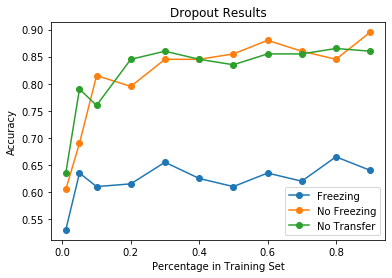

In [31]:
plt.plot(plt_arr,ff_test_freeze,'-o',label="Freezing")
plt.plot(plt_arr,ff_test_no_freeze,'-o', label = "No Freezing")
plt.plot(plt_arr,ff_test_no_transfer,'-o', label = "No Transfer")
plt.title("Dropout Results")
plt.ylabel("Accuracy")
plt.xlabel("Percentage in Training Set")
plt.legend()
plt.show()

# **Case 3**: No Dropout, 5 Hidden Layers

## Get Pre-Trained Models

In [32]:
tfidf = TfidfVectorizer(input='filename')
pretrain_data = tfidf.fit_transform(np.append(ben_some_names,np.array(mal_some_names)))

In [35]:
ff_hid_dim = 30
hid_layers = 5
no_valid_paths = True

if no_valid_paths:
    if exists('./ffn_net.pth'): os.remove('./ffn_net.pth')
    #set labels for pre-trained data
    pretrain_labels = np.append(np.zeros(len(ben_some_names)),np.ones(len(mal_some_names)))
    #size of batches
    batch_size = 200
    pre_train(pretrain_data,pretrain_labels,hid_layers=hid_layers,batch_size=batch_size,ff_hid_dim=ff_hid_dim,dropout=False,ff_epochs=10000)

epoch : 1000/10000, loss = 0.014945670729503036, accuracy = 0.9961885213851929
epoch : 2000/10000, loss = 0.006090823522148033, accuracy = 0.9982674717903137
epoch : 3000/10000, loss = 0.004709491097795156, accuracy = 0.9982674717903137
epoch : 4000/10000, loss = 0.005055610733688809, accuracy = 0.9982674717903137
epoch : 5000/10000, loss = 0.004447556508724423, accuracy = 0.9982674717903137
epoch : 6000/10000, loss = 0.002568256199371414, accuracy = 0.9986140131950378
epoch : 7000/10000, loss = 0.005662414423810939, accuracy = 0.9982674717903137
epoch : 8000/10000, loss = 0.004095353605225682, accuracy = 0.9986140131950378
epoch : 9000/10000, loss = 0.0027056947925302665, accuracy = 0.9986140131950378
epoch : 10000/10000, loss = 0.002995027771491247, accuracy = 0.9986140131950378


In [36]:
#generate random indices of benign binaries to pair with malware sets
idx = np.random.choice(np.arange(len(ben_names)),size = len(mal_none_names)+len(mal_some_names))

#generate the benign pairs for malware detected by av software
pair_some_i = idx[:len(mal_some_names)]
ben_some_names = np.array(ben_names)[pair_some_i]

#generate the benign pairs for malware not detected by av software
pair_none_i = idx[len(mal_some_names):]
ben_none_names = np.array(ben_names)[pair_none_i]

## Get Data and Labels for Transfer Data

In [37]:
transfer_data = tfidf.transform(np.append(ben_none_names,np.array(mal_none_names)))
transfer_labels = np.append(np.zeros(len(ben_none_names)),np.ones(len(mal_none_names)))

## Get Network for Freezing a Single Layer

In [38]:
ff_net_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers,dropout=False)
ff_net_freeze.load_state_dict(torch.load('ffn_net.pth'))
set_parameter_requires_grad(ff_net_freeze, True)
ff_net_freeze.L2 = nn.Linear(ff_hid_dim,2)

## Get Network for Transfer With No Freezing

In [39]:
ff_net_no_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers,dropout=False)
ff_net_no_freeze.load_state_dict(torch.load('ffn_net.pth'))

<All keys matched successfully>

## Train The NNs

In [40]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99] # the percentages of training data in the validation set
plt_arr = [1 - i for i in val_per_arr] #make array signifying percentage in training set
ff_train_freeze,ff_val_freeze,ff_test_freeze = kfold_val(ff_net_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_train_no_freeze,ff_val_no_freeze,ff_test_no_freeze = kfold_val(ff_net_no_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_net_no_transfer = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers,dropout=False) #network for no transfer
ff_train_no_transfer,ff_val_no_transfer,ff_test_no_transfer = kfold_val(ff_net_no_transfer,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)

Percentage of Training Data in Validation Set : 0.1
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6154277324676514, accuracy = 0.6527777910232544
epoch : 2000/10000, loss = 0.5913025140762329, accuracy = 0.6736111044883728
epoch : 3000/10000, loss = 0.5758081078529358, accuracy = 0.6736111044883728
epoch : 4000/10000, loss = 0.5611706972122192, accuracy = 0.7083333134651184
epoch : 5000/10000, loss = 0.5488241314888, accuracy = 0.7222222089767456
epoch : 6000/10000, loss = 0.5389879941940308, accuracy = 0.7222222089767456
epoch : 7000/10000, loss = 0.5313332080841064, accuracy = 0.7291666865348816
epoch : 8000/10000, loss = 0.5256686210632324, accuracy = 0.7291666865348816
epoch : 9000/10000, loss = 0.5218167901039124, accuracy = 0.7291666865348816
epoch : 10000/10000, loss = 0.519259512424469, accuracy = 0.7361111044883728
Validation Accuracy = 0.375
Test Accuracy = 0.574999988079071
FOLD 2/5
Reset trainab

epoch : 1000/10000, loss = 0.6557925343513489, accuracy = 0.609375
epoch : 2000/10000, loss = 0.6258415579795837, accuracy = 0.6484375
epoch : 3000/10000, loss = 0.6059820055961609, accuracy = 0.703125
epoch : 4000/10000, loss = 0.5934215188026428, accuracy = 0.7109375
epoch : 5000/10000, loss = 0.5831697583198547, accuracy = 0.7109375
epoch : 6000/10000, loss = 0.5722677111625671, accuracy = 0.7109375
epoch : 7000/10000, loss = 0.5604656338691711, accuracy = 0.7109375
epoch : 8000/10000, loss = 0.5492905974388123, accuracy = 0.71875
epoch : 9000/10000, loss = 0.5414006114006042, accuracy = 0.71875
epoch : 10000/10000, loss = 0.5361550450325012, accuracy = 0.71875
Validation Accuracy = 0.65625
Test Accuracy = 0.625
Average Training Accuracy: 0.714062511920929
Average Validation Accuracy: 0.675000011920929
Average Testing Accuracy: 0.6399999856948853
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, 

epoch : 9000/10000, loss = 0.5188714861869812, accuracy = 0.78125
epoch : 10000/10000, loss = 0.5178216099739075, accuracy = 0.7708333134651184
Validation Accuracy = 0.609375
Test Accuracy = 0.7250000238418579
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6294541358947754, accuracy = 0.6354166865348816
epoch : 2000/10000, loss = 0.5888846516609192, accuracy = 0.71875
epoch : 3000/10000, loss = 0.57005375623703, accuracy = 0.7708333134651184
epoch : 4000/10000, loss = 0.5612737536430359, accuracy = 0.7708333134651184
epoch : 5000/10000, loss = 0.555010974407196, accuracy = 0.7604166865348816
epoch : 6000/10000, loss = 0.5485724806785583, accuracy = 0.7604166865348816
epoch : 7000/10000, loss = 0.5419707894325256, accuracy = 0.7708333134651184
epoch : 8000/10000, loss = 0.5365883708000183, accuracy = 0.7708333134651184
epoch : 9000/10000, loss = 0.5328757166862488, accuracy = 0.7708333134651184
epoch : 10000/

epoch : 7000/10000, loss = 0.44819211959838867, accuracy = 0.8125
epoch : 8000/10000, loss = 0.43723881244659424, accuracy = 0.84375
epoch : 9000/10000, loss = 0.42745479941368103, accuracy = 0.859375
epoch : 10000/10000, loss = 0.4188040494918823, accuracy = 0.859375
Validation Accuracy = 0.59375
Test Accuracy = 0.6499999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6096552610397339, accuracy = 0.625
epoch : 2000/10000, loss = 0.5905730724334717, accuracy = 0.640625
epoch : 3000/10000, loss = 0.572384774684906, accuracy = 0.734375
epoch : 4000/10000, loss = 0.5566909313201904, accuracy = 0.75
epoch : 5000/10000, loss = 0.5435540676116943, accuracy = 0.765625
epoch : 6000/10000, loss = 0.5321283340454102, accuracy = 0.78125
epoch : 7000/10000, loss = 0.5211849808692932, accuracy = 0.78125
epoch : 8000/10000, loss = 0.5102275013923645, accuracy = 0.78125
epoch : 9000/10000, loss = 0.500079870223999

epoch : 8000/10000, loss = 0.5399853587150574, accuracy = 0.71875
epoch : 9000/10000, loss = 0.530526340007782, accuracy = 0.71875
epoch : 10000/10000, loss = 0.5241787433624268, accuracy = 0.71875
Validation Accuracy = 0.5859375
Test Accuracy = 0.4749999940395355
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.5791962146759033, accuracy = 0.75
epoch : 2000/10000, loss = 0.5341715216636658, accuracy = 0.78125
epoch : 3000/10000, loss = 0.5077879428863525, accuracy = 0.78125
epoch : 4000/10000, loss = 0.49040743708610535, accuracy = 0.78125
epoch : 5000/10000, loss = 0.47852009534835815, accuracy = 0.78125
epoch : 6000/10000, loss = 0.47033676505088806, accuracy = 0.78125
epoch : 7000/10000, loss = 0.46466585993766785, accuracy = 0.78125
epoch : 8000/10000, loss = 0.4607070982456207, accuracy = 0.71875
epoch : 9000/10000, loss = 0.4578315019607544, accuracy = 0.75
epoch : 10000/10000, loss = 0.4558587968349457

epoch : 3000/10000, loss = 0.5702835917472839, accuracy = 0.75
epoch : 4000/10000, loss = 0.5365217924118042, accuracy = 0.75
epoch : 5000/10000, loss = 0.5109893679618835, accuracy = 0.75
epoch : 6000/10000, loss = 0.49342697858810425, accuracy = 0.75
epoch : 7000/10000, loss = 0.4811975657939911, accuracy = 0.75
epoch : 8000/10000, loss = 0.47158244252204895, accuracy = 0.75
epoch : 9000/10000, loss = 0.46302905678749084, accuracy = 0.75
epoch : 10000/10000, loss = 0.4554099142551422, accuracy = 0.75
Validation Accuracy = 0.375
Test Accuracy = 0.42500001192092896
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 0.6073951721191406, accuracy = 0.75
epoch : 2000/10000, loss = 0.5133039951324463, accuracy = 0.875
epoch : 3000/10000, loss = 0.4292181134223938, accuracy = 0.875
epoch : 4000/10000, loss = 0.3672175109386444, accuracy = 0.875
epoch : 5000/10000, loss = 0.3236426115036011, accuracy = 0.875
epoch : 6000

epoch : 1000/10000, loss = 4.0579820961283986e-06, accuracy = 1.0
epoch : 2000/10000, loss = 8.493615268889698e-07, accuracy = 1.0
epoch : 3000/10000, loss = 3.1457940963264264e-07, accuracy = 1.0
epoch : 4000/10000, loss = 1.4238872836358496e-07, accuracy = 1.0
epoch : 5000/10000, loss = 6.871087521176378e-08, accuracy = 1.0
epoch : 6000/10000, loss = 3.642505319589873e-08, accuracy = 1.0
epoch : 7000/10000, loss = 1.8212526597949363e-08, accuracy = 1.0
epoch : 8000/10000, loss = 1.0761948665560794e-08, accuracy = 1.0
epoch : 9000/10000, loss = 4.139211196019232e-09, accuracy = 1.0
epoch : 10000/10000, loss = 2.4835267176115394e-09, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.925000011920929
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Rese

epoch : 4000/10000, loss = 5.5879343818787675e-08, accuracy = 1.0
epoch : 5000/10000, loss = 2.607702853651972e-08, accuracy = 1.0
epoch : 6000/10000, loss = 1.3969836842875338e-08, accuracy = 1.0
epoch : 7000/10000, loss = 5.587935003603661e-09, accuracy = 1.0
epoch : 8000/10000, loss = 3.725290076417309e-09, accuracy = 1.0
epoch : 9000/10000, loss = 9.313225191043273e-10, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.90625
Test Accuracy = 0.8999999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Li

epoch : 7000/10000, loss = 2.1287371865241766e-09, accuracy = 1.0
epoch : 8000/10000, loss = 1.0643685932620883e-09, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.7916666865348816
Test Accuracy = 0.949999988079071
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 3.994486633018823e-06, accuracy = 1.0
e

epoch : 7000/10000, loss = 3.2285843332147124e-08, accuracy = 1.0
epoch : 8000/10000, loss = 1.4901158529312397e-08, accuracy = 1.0
epoch : 9000/10000, loss = 9.934105982267738e-09, accuracy = 1.0
epoch : 10000/10000, loss = 2.4835267176115394e-09, accuracy = 1.0
Validation Accuracy = 0.890625
Test Accuracy = 0.824999988079071
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 1.6924899455

epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.862500011920929
Test Accuracy = 0.8999999761581421
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.8649999499320984
Average Testing Accuracy: 0.8649999499320984
Percentage of Training Data in Validation Set : 0.6
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, lo

epoch : 1000/10000, loss = 1.1783722584368661e-05, accuracy = 1.0
epoch : 2000/10000, loss = 2.5232329790014774e-06, accuracy = 1.0
epoch : 3000/10000, loss = 9.313182545156451e-07, accuracy = 1.0
epoch : 4000/10000, loss = 4.1474808654129447e-07, accuracy = 1.0
epoch : 5000/10000, loss = 2.0116544874326792e-07, accuracy = 1.0
epoch : 6000/10000, loss = 1.0430807151351473e-07, accuracy = 1.0
epoch : 7000/10000, loss = 5.960462701182223e-08, accuracy = 1.0
epoch : 8000/10000, loss = 2.7318790785102465e-08, accuracy = 1.0
epoch : 9000/10000, loss = 1.4901158529312397e-08, accuracy = 1.0
epoch : 10000/10000, loss = 7.450580152834618e-09, accuracy = 1.0
Validation Accuracy = 0.8392857313156128
Test Accuracy = 0.949999988079071
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, b

epoch : 2000/10000, loss = 1.1175870007207322e-08, accuracy = 1.0
epoch : 3000/10000, loss = 0.0, accuracy = 1.0
epoch : 4000/10000, loss = 0.0, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.875
Test Accuracy = 0.875
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_feat

epoch : 1000/10000, loss = 2.0787060748261865e-06, accuracy = 1.0
epoch : 2000/10000, loss = 4.321334472479066e-07, accuracy = 1.0
epoch : 3000/10000, loss = 1.1920927533992653e-07, accuracy = 1.0
epoch : 4000/10000, loss = 2.9802320611338473e-08, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.8402777910232544
Test Accuracy = 0.875
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.8583332896232605
Average Testing Accuracy: 0.8600000143051147
Percentage of Training Data in Validation Set : 0.95
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters

epoch : 1000/10000, loss = 0.0, accuracy = 1.0
epoch : 2000/10000, loss = 0.0, accuracy = 1.0
epoch : 3000/10000, loss = 0.0, accuracy = 1.0
epoch : 4000/10000, loss = 0.0, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.550632894039154
Test Accuracy = 0.6000000238418579
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)

epoch : 1000/10000, loss = 1.394983337377198e-05, accuracy = 1.0
epoch : 2000/10000, loss = 2.7674377633957192e-06, accuracy = 1.0
epoch : 3000/10000, loss = 9.859551255431143e-07, accuracy = 1.0
epoch : 4000/10000, loss = 4.3296051899233134e-07, accuracy = 1.0
epoch : 5000/10000, loss = 2.110995609427846e-07, accuracy = 1.0
epoch : 6000/10000, loss = 1.0844727427183898e-07, accuracy = 1.0
epoch : 7000/10000, loss = 5.546542070078431e-08, accuracy = 1.0
epoch : 8000/10000, loss = 3.1458004201567746e-08, accuracy = 1.0
epoch : 9000/10000, loss = 1.5729002100783873e-08, accuracy = 1.0
epoch : 10000/10000, loss = 7.4505797087454084e-09, accuracy = 1.0
Validation Accuracy = 0.8125
Test Accuracy = 0.824999988079071
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Res

epoch : 1000/10000, loss = 9.098912983063201e-07, accuracy = 1.0
epoch : 2000/10000, loss = 1.5553054311112646e-07, accuracy = 1.0
epoch : 3000/10000, loss = 5.6810634418980044e-08, accuracy = 1.0
epoch : 4000/10000, loss = 2.700834400570784e-08, accuracy = 1.0
epoch : 5000/10000, loss = 1.1175869119028903e-08, accuracy = 1.0
epoch : 6000/10000, loss = 6.51925713412993e-09, accuracy = 1.0
epoch : 7000/10000, loss = 2.7939675018018306e-09, accuracy = 1.0
epoch : 8000/10000, loss = 1.8626450382086546e-09, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.9375
Test Accuracy = 0.824999988079071
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.862500011920929
Average Testing Accuracy: 0.875
Percentage of Training Data in Validation Set : 0.3
FOLD 1/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=

epoch : 1000/10000, loss = 4.38078177467105e-06, accuracy = 1.0
epoch : 2000/10000, loss = 8.357012006854347e-07, accuracy = 1.0
epoch : 3000/10000, loss = 2.9305550697245053e-07, accuracy = 1.0
epoch : 4000/10000, loss = 1.3038503254847456e-07, accuracy = 1.0
epoch : 5000/10000, loss = 5.9604616353681195e-08, accuracy = 1.0
epoch : 6000/10000, loss = 2.9802317058624794e-08, accuracy = 1.0
epoch : 7000/10000, loss = 1.4901160305669237e-08, accuracy = 1.0
epoch : 8000/10000, loss = 7.450580152834618e-09, accuracy = 1.0
epoch : 9000/10000, loss = 3.725290076417309e-09, accuracy = 1.0
epoch : 10000/10000, loss = 1.2417633588057697e-09, accuracy = 1.0
Validation Accuracy = 0.890625
Test Accuracy = 0.8500000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
R

epoch : 4000/10000, loss = 9.983773452404421e-08, accuracy = 1.0
epoch : 5000/10000, loss = 5.215405352032576e-08, accuracy = 1.0
epoch : 6000/10000, loss = 2.6822084109312527e-08, accuracy = 1.0
epoch : 7000/10000, loss = 1.3411043831013103e-08, accuracy = 1.0
epoch : 8000/10000, loss = 8.940696183401542e-09, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.8500000238418579
Test Accuracy = 0.8999999761581421
FOLD 3/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in

epoch : 7000/10000, loss = 7.264311818744318e-08, accuracy = 1.0
epoch : 8000/10000, loss = 4.2840824221457297e-08, accuracy = 1.0
epoch : 9000/10000, loss = 2.048909308882685e-08, accuracy = 1.0
epoch : 10000/10000, loss = 1.1175870007207322e-08, accuracy = 1.0
Validation Accuracy = 0.8854166865348816
Test Accuracy = 0.925000011920929
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 1.4

epoch : 8000/10000, loss = 9.685743407317204e-08, accuracy = 1.0
epoch : 9000/10000, loss = 5.215403220404369e-08, accuracy = 1.0
epoch : 10000/10000, loss = 2.9802313505911115e-08, accuracy = 1.0
Validation Accuracy = 0.8303571343421936
Test Accuracy = 0.875
FOLD 5/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=2, bias=True)
epoch : 1000/10000, loss = 1.668920049269218e-06, accuracy = 1.0
epoch : 2000/10000, loss = 3.50176833308069

epoch : 1000/10000, loss = 7.003531550253683e-07, accuracy = 1.0
epoch : 2000/10000, loss = 1.3411039390121005e-07, accuracy = 1.0
epoch : 3000/10000, loss = 4.470347647611561e-08, accuracy = 1.0
epoch : 4000/10000, loss = 1.4901160305669237e-08, accuracy = 1.0
epoch : 5000/10000, loss = 1.4901160305669237e-08, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.9027777910232544
Test Accuracy = 0.8500000238418579
FOLD 2/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=

epoch : 1000/10000, loss = 1.0430811414607888e-07, accuracy = 1.0
epoch : 2000/10000, loss = 0.0, accuracy = 1.0
epoch : 3000/10000, loss = 0.0, accuracy = 1.0
epoch : 4000/10000, loss = 0.0, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.7960526347160339
Test Accuracy = 0.7749999761581421
FOLD 4/5
Reset trainable parameters of layer = Linear(in_features=892, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_features=30, bias=True)
Reset trainable parameters of layer = Linear(in_features=30, out_fea

epoch : 1000/10000, loss = 5.9604641222676946e-08, accuracy = 1.0
epoch : 2000/10000, loss = 0.0, accuracy = 1.0
epoch : 3000/10000, loss = 0.0, accuracy = 1.0
epoch : 4000/10000, loss = 0.0, accuracy = 1.0
epoch : 5000/10000, loss = 0.0, accuracy = 1.0
epoch : 6000/10000, loss = 0.0, accuracy = 1.0
epoch : 7000/10000, loss = 0.0, accuracy = 1.0
epoch : 8000/10000, loss = 0.0, accuracy = 1.0
epoch : 9000/10000, loss = 0.0, accuracy = 1.0
epoch : 10000/10000, loss = 0.0, accuracy = 1.0
Validation Accuracy = 0.6582278609275818
Test Accuracy = 0.699999988079071
Average Training Accuracy: 1.0
Average Validation Accuracy: 0.541772186756134
Average Testing Accuracy: 0.47999995946884155


### Plot of the Above

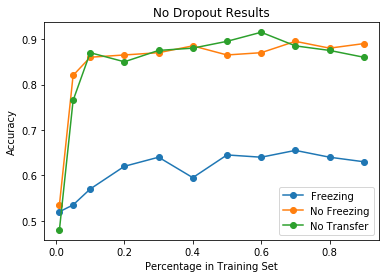

In [41]:
plt.plot(plt_arr,ff_test_freeze,'-o',label="Freezing")
plt.plot(plt_arr,ff_test_no_freeze,'-o', label = "No Freezing")
plt.plot(plt_arr,ff_test_no_transfer,'-o', label = "No Transfer")
plt.title("No Dropout Results")
plt.ylabel("Accuracy")
plt.xlabel("Percentage in Training Set")
plt.legend()
plt.show()

# **Case 4**: Dropout, 5 Hidden Layers
## Get Pre-Trained Models

In [26]:
tfidf = TfidfVectorizer(input='filename')
pretrain_data = tfidf.fit_transform(np.append(ben_some_names,np.array(mal_some_names)))

In [27]:
ff_hid_dim = 30
hid_layers = 5
no_valid_paths = True

if no_valid_paths:
    if exists('./ffn_net.pth'): os.remove('./ffn_net.pth')
    #set labels for pre-trained data
    pretrain_labels = np.append(np.zeros(len(ben_some_names)),np.ones(len(mal_some_names)))
    #size of batches
    batch_size = 200
    pre_train(pretrain_data,pretrain_labels,hid_layers=hid_layers,batch_size=batch_size,ff_hid_dim=ff_hid_dim,dropout=True,ff_epochs=10000)

epoch : 1000/10000, loss = 0.16931160936752956, accuracy = 0.9268884062767029
epoch : 2000/10000, loss = 0.15834939181804658, accuracy = 0.9358974099159241


KeyboardInterrupt: 

## Get Data and Labels for Transfer Data

In [ ]:
transfer_data = tfidf.transform(np.append(ben_none_names,np.array(mal_none_names)))
transfer_labels = np.append(np.zeros(len(ben_none_names)),np.ones(len(mal_none_names)))

## Get Network for Freezing a Single Layer

In [ ]:
ff_net_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers)
ff_net_freeze.load_state_dict(torch.load('ffn_net.pth'))
set_parameter_requires_grad(ff_net_freeze, True)
ff_net_freeze.L2 = nn.Linear(ff_hid_dim,2)

## Get Network for Transfer With No Freezing

In [ ]:
ff_net_no_freeze = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers)
ff_net_no_freeze.load_state_dict(torch.load('ffn_net.pth'))

## Train The NNs

In [ ]:
val_per_arr = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99] # the percentages of training data in the validation set
plt_arr = [1 - i for i in val_per_arr] #make array signifying percentage in training set
ff_train_freeze,ff_val_freeze,ff_test_freeze = kfold_val(ff_net_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_train_no_freeze,ff_val_no_freeze,ff_test_no_freeze = kfold_val(ff_net_no_freeze,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)
ff_net_no_transfer = FeedForward(transfer_data.shape[1],ff_hid_dim,2,hid_layers=hid_layers) #network for no transfer
ff_train_no_transfer,ff_val_no_transfer,ff_test_no_transfer = kfold_val(ff_net_no_transfer,val_per_arr,transfer_data,transfer_labels,idx=np.arange(200),batch_size=200,num_epochs=10000)

### Plot of the Above

In [ ]:
plt.plot(plt_arr,ff_test_freeze,'-o',label="Freezing")
plt.plot(plt_arr,ff_test_no_freeze,'-o', label = "No Freezing")
plt.plot(plt_arr,ff_test_no_transfer,'-o', label = "No Transfer")
plt.title("Dropout Results")
plt.ylabel("Accuracy")
plt.xlabel("Percentage in Training Set")
plt.legend()
plt.show()